In [48]:
import spacy
import sys
import re
import liwc
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from nltk.corpus import stopwords
from empath import Empath
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
from IPython.display import Markdown, display

In [49]:
pd.set_option('colheader_justify', 'left')

def printmd(string):
    display(Markdown(string))

## Load Files
Load a list of the individual transcript files from DTRS-7, 10, and 11. It's probably a good idea to check this list periodically to check if it needs updating.

In [2]:
with open('data/filenames.txt') as fo:
    filenames = fo.read()
filenames=filenames.split('\n')

## Read all lines as a single string
We first combine all files into a single string before separating them into lines containing speaker-utterance pairs.

In [3]:
def read_file_into_string(file_name, dir_name='data/'):
    if file_name != '' :
        file_path = dir_name+file_name
        with open(file_path) as f:
            sentences_string = f.read()
        return sentences_string
    else :
        print('no file read')
        return ''

## Clean Text, Break Lines
The text has several unnecessary characters such as carriage returns in the middle of sentences, tabs, square braces, time stamps etc. For now we remove only the tabs and carriage returns, but we may need to remove timestamps as well.

The cleaned text will then be broken into lines such that each speaker and the corresponding utterance gets a separate line. 

In [4]:
def clean_text(input_text):
    text_without_carriage_returns = input_text.replace('\r', ' ').replace('\n', ' ')
    text_without_tabs = text_without_carriage_returns.replace('\t', ' ')
    # add other code to remove special characters that need removing here
    cleaned_text = text_without_tabs
    return cleaned_text

def break_lines(input_str):
    text_linebreaks_str = re.sub("[a-zA-Z]+:", '\n'+'\g<0>', input_str)
    lines_output = text_linebreaks_str.split('\n')
    lines_without_blanks = [line.strip() for line in lines_output if line != '']
    return lines_without_blanks

## Convert to Dataframe
Convert the text in the format `speaker: utterance` into a pandas dataframe with separate columns for `speaker` and `utterance`.

In [5]:
def convert_text_to_columns(string_list, additional_columns):
    data_columns = []
    i=0
    for line in string_list:
        split_dialogue = line.split(':')
        if len(split_dialogue) > 2 :
            speaker = split_dialogue[0].strip()
            remaining_dialogue = ':'.join(split_dialogue[1:]).strip()
        elif len(split_dialogue) == 2 :
            speaker = split_dialogue[0].strip()
            remaining_dialogue = split_dialogue[1].strip()
        elif len(split_dialogue) < 2:
            print("weird format!")
            print(dialogue)
            print("-----")
            continue
        data_columns.append(additional_columns + [speaker, remaining_dialogue])
    return data_columns

def write_csv(df, file_name, column_names, write_path='output/'):
    df.applymap(lambda x: x.replace('"', ''))
    df.applymap(lambda x: x.replace(';', ','))
    df.to_csv(write_path+file_name, sep=';', columns=column_names, index=False, header=True)


def convert_file_to_dataframe(file_name,
                              dir_name='data/',
                              write_output_file=False,
                              output_dir='output/'):
    dataset_name = ('-').join(file_name.split('-')[0:2])
    session_name = ('-').join(file_name.split('-')[2:]).split('.')[0]
    file_content = read_file_into_string(file_name, dir_name=dir_name)
    column_names = ['dataset', 'session', 'speaker', 'utterance']
    lines = break_lines(clean_text(file_content))
    columns_to_add = [dataset_name, session_name]
    text_columns = convert_text_to_columns(lines, columns_to_add)
    df = pd.DataFrame(text_columns, columns=column_names)
    if write_output_file :
        write_csv(df)
    return df


In [6]:
df = None
for filename in filenames:
    if filename == '' or filename == ' ' :
        continue
    if df is None :
        df = convert_file_to_dataframe(filename)
    else :
        df_to_append = convert_file_to_dataframe(filename)
        df = df.append(df_to_append)
        
print(df.shape)
df[6240:6245]

(20902, 4)


,dataset,session,speaker,utterance
37,dtrs-07,engineers-meeting-02,MaleA,Erm you have to follow the You don't necessar...
38,dtrs-07,engineers-meeting-02,MaleE,So the quality of the image would depend on the-
39,dtrs-07,engineers-meeting-02,MaleA,The qual-
40,dtrs-07,engineers-meeting-02,MaleE,nominal speed and how you would match that if ...
41,dtrs-07,engineers-meeting-02,MaleA,Yeah absolutely yeah


In [ ]:
# df_filter = df[df['dataset'] == 'dtrs-11']
# utt = list(df_filter['utterance'])
# with open('dtrs-11-utterances.txt', 'w') as f:
#     for item in utt:
#         f.write("%s\n" % item)
        

In [7]:
for ind, utterance in enumerate(list(df['utterance'])) :
    if utterance == '' or utterance == ' ' :
        print(ind)

## Prepare Text for Word Embedding
Steps still need to be finalized, but it involves tokenization, stop word removal, identification of n-grams, and (to some extent) parts-of-speech tagging. Not sure at this point if lemmatization will help or harm the proposed work.

In [8]:
nlp = spacy.load("en_core_web_sm")
stop_list = stopwords.words('English')

### Tokenization
Tokenize each line into words, remove punctuations.

In [9]:
utterances = list(df['utterance'])
doc_list = []

for utterance in utterances:
    doc = nlp(utterance)
    doc_list.append(doc)

In [10]:
lookups = Lookups()
lemmatizer = Lemmatizer(lookups)
doc = doc_list[0]
print(len(doc_list), len(utterances))
for token in doc:
    lemma = lemmatizer(token, token.pos_)
    print(token, lemma, token.pos_)

20902 20902
Before [Before] ADP
I [I] PRON
give [give] VERB
you [you] PRON
the [the] DET
design [design] NOUN
brief [brief] NOUN
, [,] PUNCT
are [are] AUX
there [there] PRON
any [any] DET
questions [questions] NOUN
about [about] ADP
the [the] DET
procedure [procedure] NOUN
? [?] PUNCT
( [(] PUNCT
00:14:00 [00:14:00] PUNCT
) [)] PUNCT


In [11]:
token_pos = []
token_list = []
token_counts = []
for doc in doc_list:
    token_utterance = []
    tokens = []
    token_count = 0
    for token in doc:
        token_utterance.append((token, token.pos_))
        if token.pos_ != 'PUNCT' :
            tokens.append(str(token).lower())
            token_count += 1
        token_pos.append(token_utterance)
        token_list.append(tokens)
    token_counts.append(token_count)

df.insert(4, 'word count', token_counts, True)

In [12]:
df[1253:1258]

,dataset,session,speaker,utterance,word count
922,dtrs-02,three-person-discussion,Ivan,the seat post was what,5
923,dtrs-02,three-person-discussion,John,kinda disrupted our materials discussion but (...,10
924,dtrs-02,three-person-discussion,Ivan,that's OK,3
925,dtrs-02,three-person-discussion,John,when Kerry started talking about sorta the str...,19
926,dtrs-02,three-person-discussion,Kerry,I think you're right I mean we've already got ...,40


In [13]:
"""
model=Word2Vec(token_list,
              min_count=3, # ignore words less frequent than this number
              size=200,    # vector size
              workers=2,   # number of processors
              window=5,    # size of window (in number of words) for context during training
              iter=30      # number of epochs for training over the corpus
              )
print(len(model.wv.vocab), 'words in current model')
model.most_similar('would')
"""

"\nmodel=Word2Vec(token_list,\n              min_count=3, # ignore words less frequent than this number\n              size=200,    # vector size\n              workers=2,   # number of processors\n              window=5,    # size of window (in number of words) for context during training\n              iter=30      # number of epochs for training over the corpus\n              )\nprint(len(model.wv.vocab), 'words in current model')\nmodel.most_similar('would')\n"

## Empath Analysis

In [14]:
lexicon = Empath()
dd = lexicon.analyze("he hit the other person", normalize=True)
empath_categories = [
     'help', 'office', 'dance', 'money', 'wedding', 'domestic_work',
     'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness',
     'aggression', 'occupation', 'envy', 'anticipation', 'family',
     'vacation', 'crime', 'attractive', 'masculine', 'prison',
     'health', 'pride', 'dispute', 'nervousness', 'government',
     'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering',
     'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic',
     'beach', 'journalism', 'morning', 'banking', 'social_media',
     'exercise', 'night', 'kill', 'blue_collar_job', 'art',
     'ridicule', 'play', 'computer', 'college', 'optimism',
     'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear',
     'irritability', 'superhero', 'business', 'driving', 'pet',
     'childish', 'cooking', 'exasperation', 'religion', 'hipster',
     'internet', 'surprise', 'reading', 'worship', 'leader',
     'independence', 'movement', 'body', 'noise', 'eating',
     'medieval', 'zest', 'confusion', 'water', 'sports', 'death',
     'healing', 'legend', 'heroic', 'celebration', 'restaurant',
     'violence', 'programming', 'dominant_heirarchical', 'military',
     'neglect', 'swimming', 'exotic', 'love', 'hiking',
     'communication', 'hearing', 'order', 'sympathy', 'hygiene',
     'weather', 'anonymity', 'trust', 'ancient', 'deception',
     'fabric', 'air_travel', 'fight', 'dominant_personality',
     'music', 'vehicle', 'politeness', 'toy', 'farming', 'meeting',
     'war', 'speaking', 'listen', 'urban', 'shopping', 'disgust',
     'fire', 'tool', 'phone', 'gain', 'sound', 'injury', 'sailing',
     'rage', 'science', 'work', 'appearance', 'valuable', 'warmth',
     'youth', 'sadness', 'fun', 'emotional', 'joy', 'affection',
     'traveling', 'fashion', 'ugliness', 'lust', 'shame', 'torment',
     'economics', 'anger', 'politics', 'ship', 'clothing', 'car',
     'strength', 'technology', 'breaking', 'shape_and_size', 'power',
     'white_collar_job', 'animal', 'party', 'terrorism', 'smell',
     'disappointment', 'poor', 'plant', 'pain', 'beauty', 'timidity',
     'philosophy', 'negotiate', 'negative_emotion', 'cleaning',
     'messaging', 'competing', 'law', 'friends', 'payment',
     'achievement', 'alcohol', 'liquid', 'feminine', 'weapon',
     'children', 'monster', 'ocean', 'giving', 'contentment',
     'writing', 'rural', 'positive_emotion', 'musical'
]
    
spatial_cues =  ['office', 'wedding', 'prison', 'furniture', 'school']
locations = lexicon.create_category("locations",
                                    ["office","prison","school", "hospital", "mall", "church"], 
                                    model='nytimes')
locations

["hospital", "school", "parish", "clinic", "church", "jail", "Rikers_Island", "office", "synagogue", "courthouse", "prison", "dormitory", "group_home", "homeless_shelter", "day_care_center", "school_building", "community_center", "mosque", "Rikers", "congregation", "family", "shelters", "ward", "public_school", "shelter", "firehouse", "house", "halfway_house", "elementary_school", "convent", "health_clinic", "diocese", "rectory", "day-care_center", "motel", "inmates", "community", "post_office", "homeless_families", "police_station", "housing_project", "ministry", "neighborhood", "Mr._Hogue", "city", "apartment", "homeless_men"]


In [34]:
lexicon.create_category('movement-reddit', 
                                   ['walk', 'move', 'fly', 'roll', 'skate', 'crawl', 'swim', 'drive', 'bike', 'sail'], model="reddit")
movement_reddit = list(set(lexicon.cats['movement-reddit']))


["swim", "walk", "paddle", "ride", "crawl", "scoot", "paddling", "drag", "swim", "waddle", "gallop", "jump", "Swim", "feet", "fly", "pedal", "trail", "skate", "slip", "haul", "slide", "jog", "jog", "crawl", "climb_trees", "chase", "walk", "faceplant", "boat", "catch", "knuckle", "riding", "hike", "fling", "uphill", "snowboard", "swimming", "long_board", "float", "hop", "sprint", "raft", "bonk", "hike", "walk/run", "dismount", "mosey", "limp", "train", "scurry", "whack", "ditch", "skateboard", "duck", "kayak", "huck", "ski", "saunter", "wheel", "dart", "paddling", "sideways", "sail", "plow", "yank", "fly", "loaf", "dive", "head", "drive", "legs", "kayak", "town", "lumber", "lay", "step", "skateboard", "hump", "sit", "climb", "shimmy", "pound", "scoot", "trail", "zip", "soft_sand", "long_ride", "feet", "glide", "trudge", "deep_water", "skid", "strap", "beach", "putter", "maneuver"]


In [36]:
lexicon.create_category('movement-nytimes', ['walk', 'move', 'fly',
                                                'roll', 'skate', 'crawl', 'swim',
                                                'drive', 'bike', 'sail'], model="nytimes")
movement_ny = list(set(lexicon.cats['movement-nytimes']))

["hop", "ride", "walk", "dive", "swim", "crawl", "pedal", "sail", "race", "drive", "ski", "fly", "jump", "row", "zip", "paddle", "jog", "cruise", "climb", "glide", "hike", "go", "sprint", "circle", "bump", "move", "wander", "skate", "park", "plow", "paddling", "crash", "hurry", "travel", "chase", "sneak", "tow", "dash", "haul", "drift", "fish", "hustle", "pull", "leap", "land", "scoot", "slip", "dart", "lug", "board", "wade", "hoist", "bounce", "strap", "slide", "clamber", "gallop", "blast", "stretch", "paddled", "roll", "descend", "skis", "venture", "stagger", "stroll", "rush", "swing", "dribble", "hook", "splash", "limp", "maneuver", "tuck", "swoop", "wheel", "pack", "buckle", "trudge", "paddle", "stow", "trip", "bike", "kick", "bike", "get", "hug", "drag", "roar", "stay", "zoom", "float", "shoot", "amble", "catch", "jam", "wiggle", "sink", "suck", "sit"]


In [37]:
lexicon.create_category('movement-fiction', ['walk', 'move', 'fly',
                                                'roll', 'skate', 'crawl', 'swim',
                                                'drive', 'bike', 'sail'], model="fiction")
movement_fiction = list(set(lexicon.cats['movement-fiction']))

["move", "fly", "walk", "climb", "drive", "swim", "pull", "drag", "paddle", "crawl", "back", "skate", "ride", "push", "reach", "swing", "jump", "jog", "race", "step", "sprint", "rush", "stand", "pass", "hop", "turn", "dive", "climb", "drop", "roll", "slide", "slip", "fall", "head", "speed", "float", "throw", "crash", "stretch", "kick", "travel", "sail", "moving", "land", "paddling", "zoom", "carry", "haul", "hike", "bounce", "sweep", "chase", "trot", "run", "dash", "limp", "gallop", "lift", "scramble", "close", "crawl", "walking", "duck", "skating", "stumble", "start", "sit", "dive", "tumble", "train_tracks", "wind", "bring", "scamper", "bend", "march", "freeze", "near", "leave", "stroll", "park", "wander", "scurry", "bike", "wade", "leap", "shoot", "shift", "running", "flip", "hold"]


In [102]:
df = df.drop('movement emphasis', axis=1)
movement_lex = []
for ind, utterance in enumerate(list(df['utterance'])) :
    if utterance == '' or utterance == ' ' :
        print(ind)
    else :
        movement_emphasis = lexicon.analyze(utterance, categories=["movement-nytimes"],
                                            normalize=True)['movement-nytimes']
        movement_lex.append(movement_emphasis)
df.insert(5, 'movement emphasis', movement_lex, True)
df[0:5]

,dataset,session,speaker,utterance,word count,movement emphasis
0,dtrs-02,think-aloud,X,"Before I give you the design brief, are there ...",14,0.0
1,dtrs-02,think-aloud,Dan,"Um No, other than the ....I have these two ref...",36,0.0
2,dtrs-02,think-aloud,X,Yes. Probably after you’ve read the brief you ...,41,0.0
3,dtrs-02,think-aloud,Dan,Alright. But you don't have the directory or a...,14,0.0
4,dtrs-02,think-aloud,X,No. The idea is not to to give you the... I me...,54,0.0


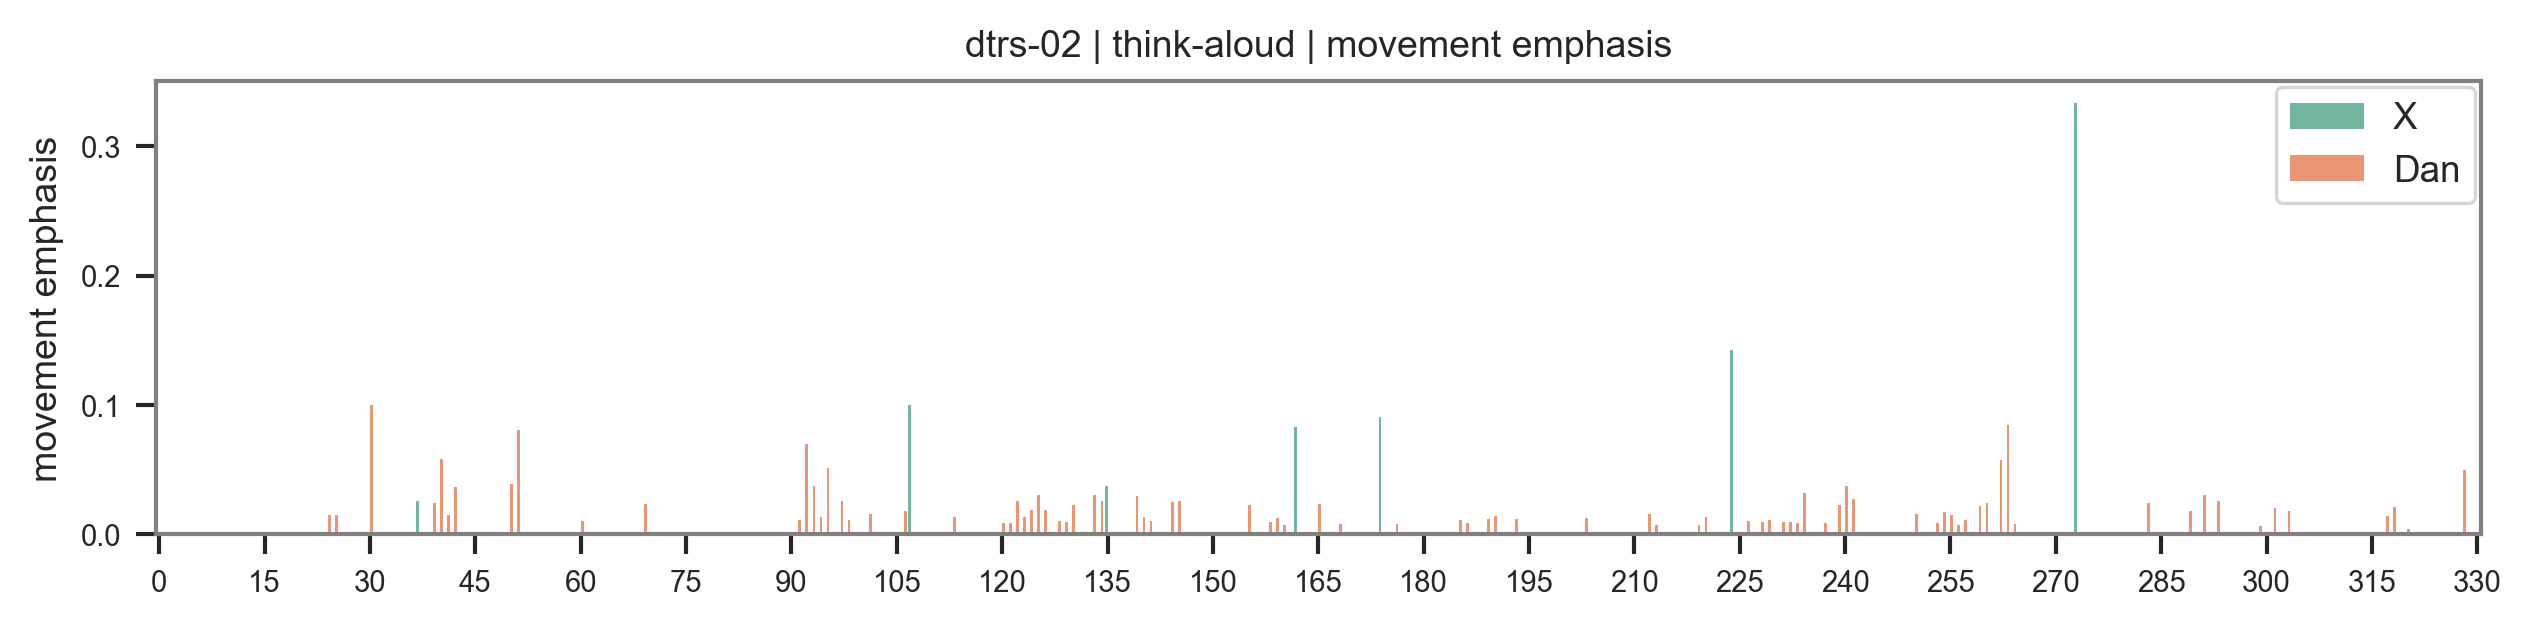

In [103]:
def myround(x, base=5):
    return base * round(x/base)

def plot_measure(df, dataset, session, measure):
    df0=df[df['dataset']==dataset]
    if session != '' :
        df1=df0[df0['session']==session]
    else :
        df1 = df0
    fig = plt.figure(figsize=[10,2], dpi=300)
    col = sns.color_palette("Set2")
    sns.set_style('ticks', {'axes.linewidth': 0.5, 'axes.edgecolor':'grey', 'axes.spinecolor' : 'grey'})
    # sns.set_theme(style="ticks")
    sns.set_context('paper', font_scale = 1)
    ax = sns.barplot(x=df1.index, y=measure, data=df1, hue='speaker', palette ='Set2', linewidth=0)
    
    xlim = df1.shape[0] + 1
    xlist = list(np.arange(0, xlim, myround(xlim/20)))
    ax.set_xticks(xlist)
    ax.set_xticklabels(ax.get_xticks(), fontsize=7)

    def round2(x):
        y = round(x, 2)
        return y
    ax.set_yticklabels(map(round2, ax.get_yticks()), fontsize=7)
    ax.set_ylabel(measure, fontsize=9)
    plt.title(dataset +' | '+ session +' | '+ measure, fontsize=9)
    speakers = len(set(list(df1['speaker'])))
    legend_columns = round(speakers/4) + 1
    plt.legend(loc='best', ncol=legend_columns, borderaxespad=0.15)
    plt.savefig('./plots/'+ dataset +'-'+ session +'-'+ measure +'.pdf', bbox_inches='tight')

plot_measure(df, 'dtrs-02', 'think-aloud', 'movement emphasis')

In [118]:
doc = nlp("this Blackburn Design yeah I'd like to talk to somebody about your em bicycle carriers")
    
doc_tokens = [token for token in doc]



[this, Blackburn, Design, yeah, I, 'd, like, to, talk, to, somebody, about, your, em, bicycle, carriers]


In [135]:
def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
    

def print_lines(df, dataset, session, lexicon, start, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    utt = list(df2['utterance'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(df2['speaker'][index])
        printmd(line_matched)
        print('----------')
print_lines(df, 'dtrs-02', 'think-aloud', movement_ny, 90, num_lines=5)

90 : Dan


blackburn design and campbell… thank you oops there we're ok alright so now i'm going to call up blackburn here (dials) yeah look er is this blackburn design yeah i'd like to talk to somebody about your em bicycle carriers. california. technical information so the phone's ringing i’ve been transferred (00:38:00)

----------
91 : Dan


to somebody here…… ok i'm going to actually., let's see .... oh., oh oh .. oh oh i haven't gotten through to the right person yet we'll see what happens here em yeah you just transferred me to somebody whose gonna talk to me about bicycle carriers they weren't there., oh i see maybe you've got right maybe you can tell me someone who could **get** me somebody who is there ok thank you., yeah maybe you can em i'm er thinking about bicycle carriers for carrying backpacks  (00:39:00)

----------
92 : Dan


on a mountain **bike** and you make various kinds you make the ones that **go** on the rear **wheel** the front **wheel** the sides., yeah the racks well i assume that i would assume that you could mount a backpack on those right...you don't make any backpack carriers specifically do you...oo...right right ok but now not all of them you could mount packs above the **bike** above the **wheel** right....i see., you don't ok well i wanted to know what's the trade off between carrying panniers on the front versus the rear, which is better on a mountain **bike** (00:40:00)

----------
93 : Dan


i see and that rear rack would be over the whe.. alongside each the rear **wheel** or above the rear **wheel** i see., above and to the side of it.. does does keeping it ...right i see ok but like for instance like like you have the expedition rack and your cross rack.. (00:41:00)

----------
94 : Dan


they're all designed so that you can mount things on top and then they just hang down the side huh...what happens if the if the centre of gravity is pretty high up above the **bike** do you have a stability problem in the rear., what happens if you did it in the front do you have it looks like you could put things high in the front or is that worse., that's the worst ok i see what about between the well there's not much space between the er in the frame i guess to put stuff ok what about the fact that it gets very wide is a mountain **bike** a problem when if you have panniers hanging down the side can people complain about that i'm i'm trying to find out what problems i'm going to have here (laugh) and pick the right...i see.. 00:42:00)

----------


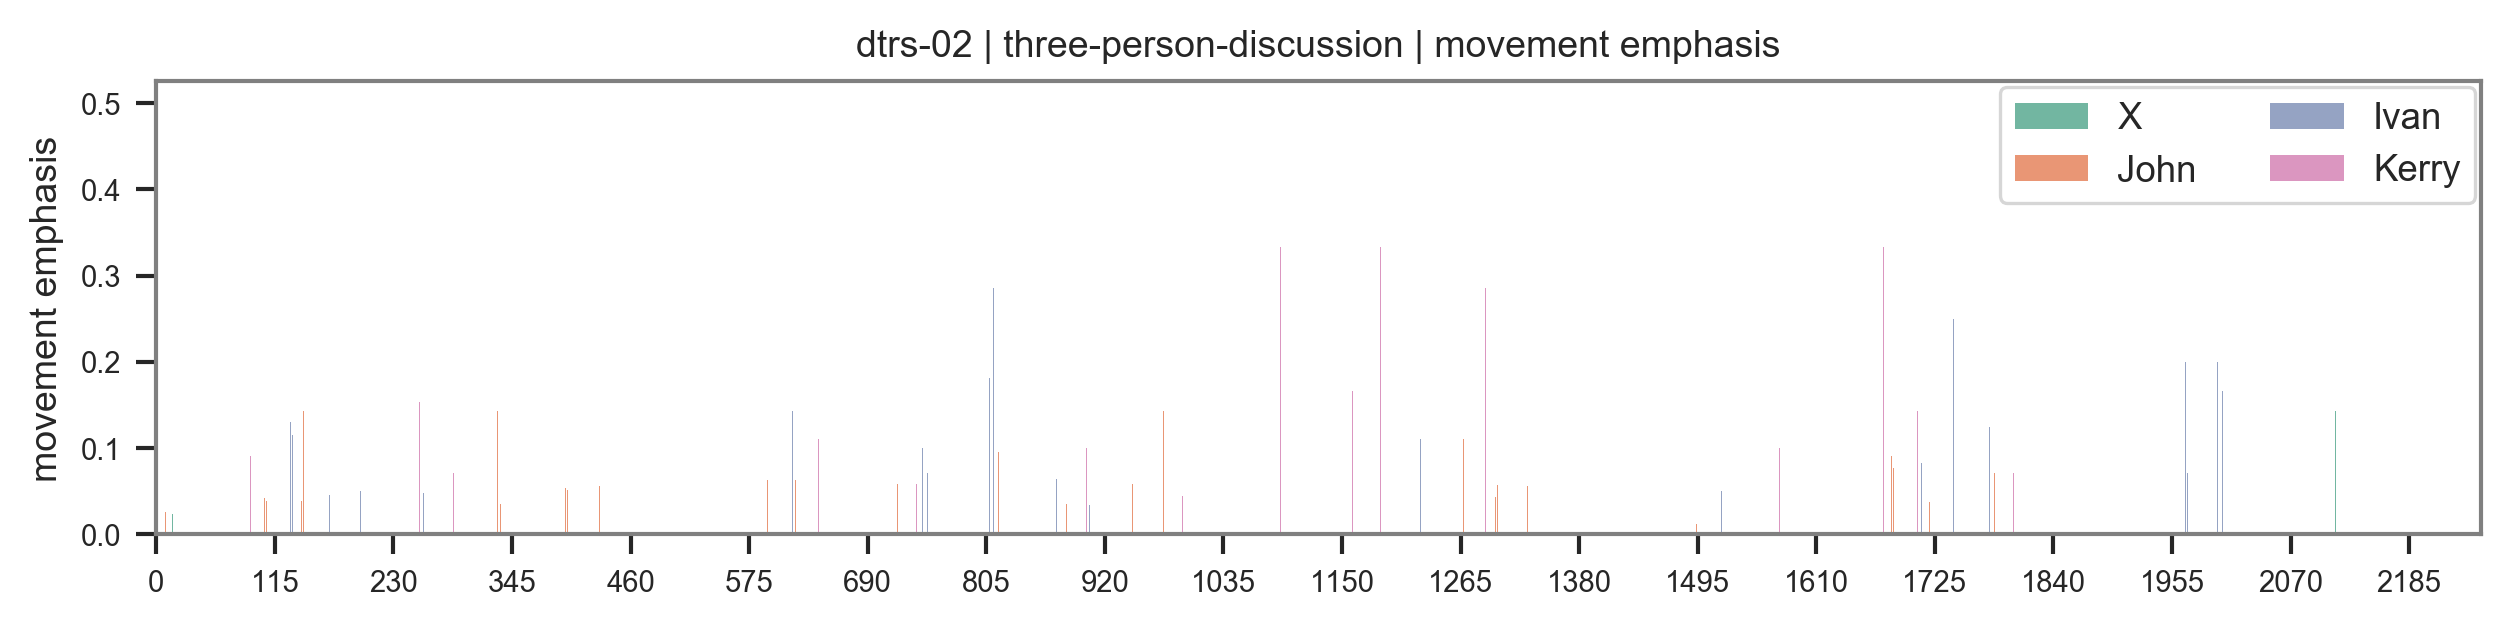

In [105]:
plot_measure(df, 'dtrs-02', 'three-person-discussion', 'movement emphasis')

In [136]:
print_lines(df, 'dtrs-02', 'three-person-discussion', movement_ny, 805, num_lines=5)

805 : Ivan


then we have the foot kicking over problem but we're on a brainstorm so

----------
806 : John


foot kicking over

----------
807 : Kerry


that was the problem that (inaudible)

----------
808 : Ivan


to try to **get** on the **bike** they don't like that

----------
809 : Kerry


the user testing they

----------


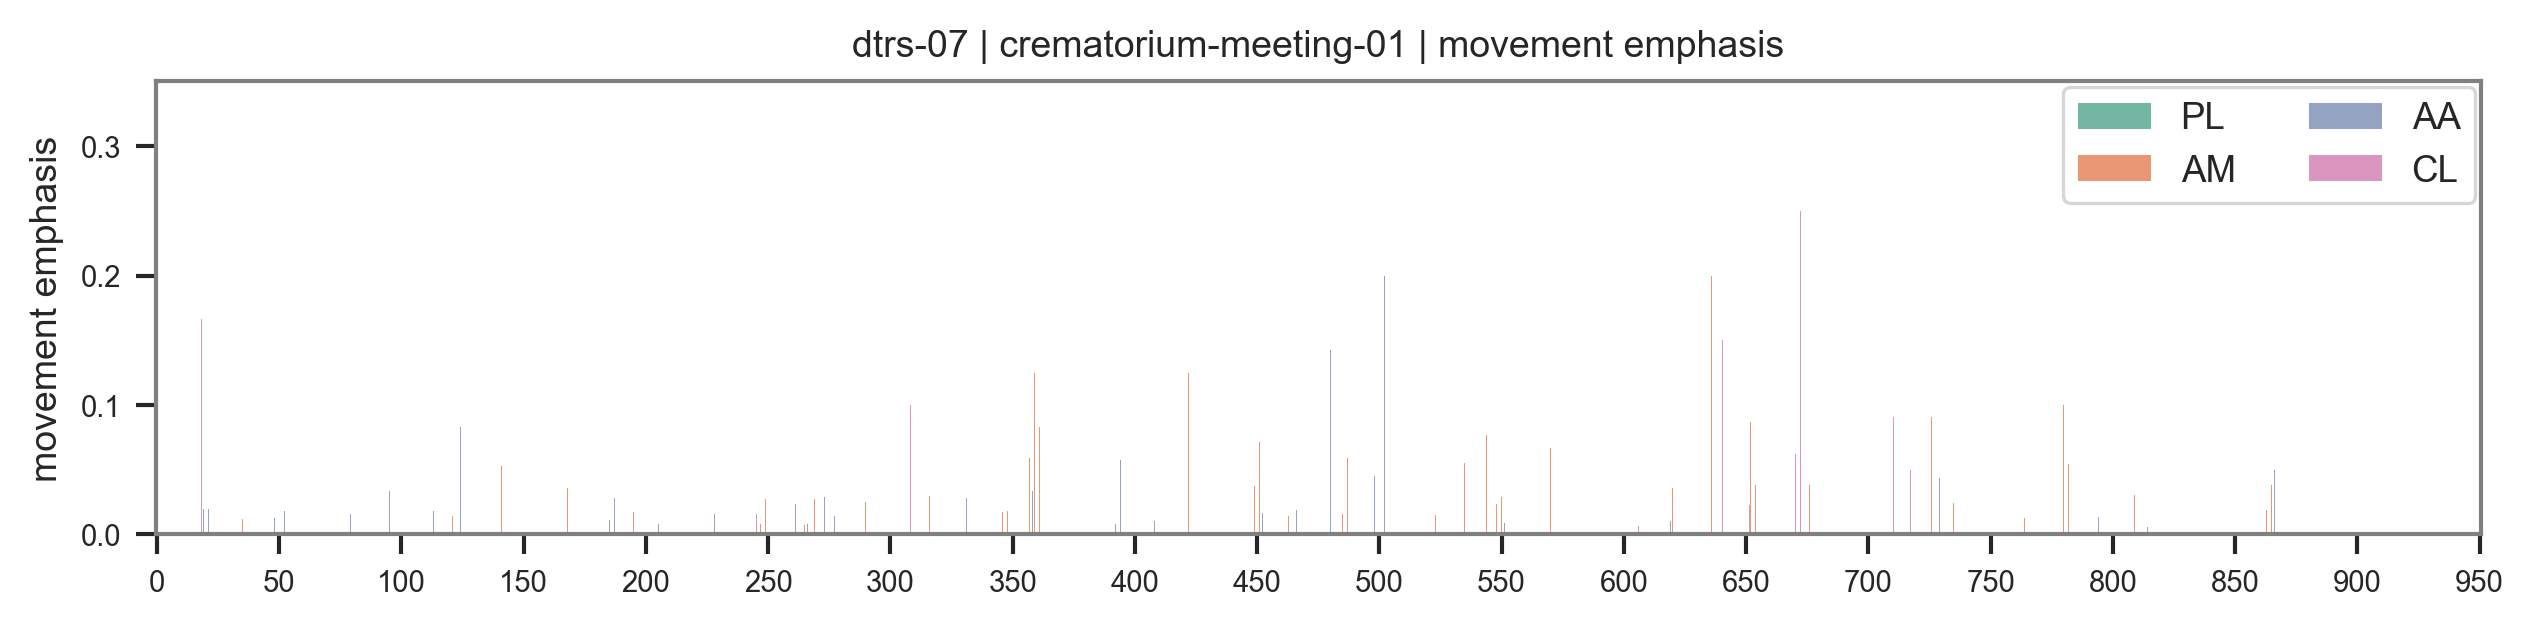

In [107]:
plot_measure(df, 'dtrs-07', 'crematorium-meeting-01', 'movement emphasis')

In [144]:
print_lines(df, 'dtrs-07', 'crematorium-meeting-01', movement_ny, 355, num_lines=15)

355 : CL


it's the charging

----------
356 : AA


charging

----------
357 : AM


the charging device, and the sikh people would be allowed to push it  into the cremator ok? beyond that of course we **get** to the back of  house, we **get** to the cremator room

----------
358 : AA


ok can i obviously ask, it seems a completely daft thing but if  people are, if sikhs are walking through after the service, they  obviously need to be able to **get** through the curtain, if we're using  curtains as our committal style. at the moment once the curtains are  closed you have to **go** through the curtains to open them

----------
359 : AM


you don't necessarily have to **go** that way

----------
360 : AA


no?

----------
361 : AM


there are three possible routes, they either come through here, one. or they **go** through here, two. or they can **go** through there, three.

----------
362 : AA


ok, that's alright, lovely

----------
363 : AM


they've got three alternative ways of getting in so [4:47] if there's  a curtaining thing there, yes you can certainly guide them through  this way, that might be the nicest way to come in, but…yeah?

----------
364 : AA


that's ok, thank you

----------
365 : AM


now beyond that i've put in a cremator area, the last time you and i  talked about this we were changing away from the original idea of  having a cool storage area into full cremators and so we've developed  the design of this end of the building with facultive, facultative  technologies,

----------
366 : AA


yes

----------
367 : AM


who've provided your present cremators, and it's all worked out in my  original concept as server and served, so that you end up with a  chimney sticking out through the servant space and not through the  very nice barrel vaulted roofs

----------
368 : AA


ok

----------
369 : AM


erm, the service yard is located here, if, once this is built if you  needed to replace a cremator well into the future these doors have  been designed to be wide enough so that you can bring equipment in and  replace it from the service yard. the service yard has a staff  entrance on it, which, erm, allows a connection for staff to the back  of the building if you like, the staff entrance links them straight  into the staff room, which has a kitchenette

----------


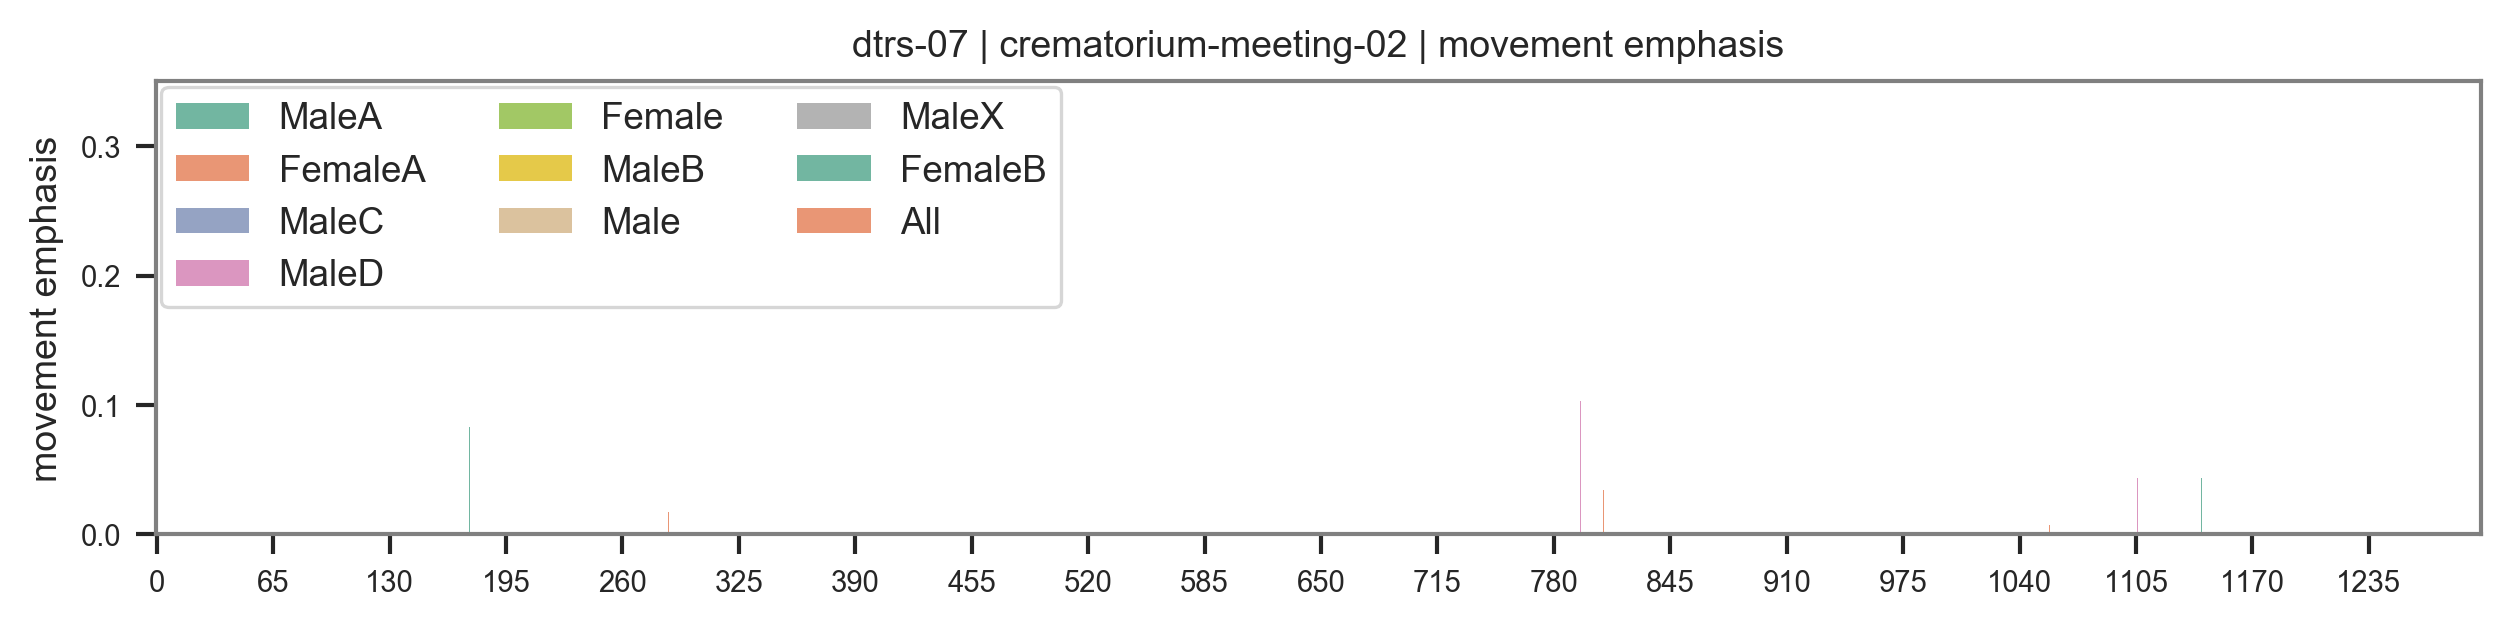

In [108]:
plot_measure(df, 'dtrs-07', 'crematorium-meeting-02', 'movement emphasis')

In [141]:
print_lines(df, 'dtrs-07', 'crematorium-meeting-02', movement_ny, 783, num_lines=5)

783 : FemaleA


[laugh]

----------
784 : MaleA


because err,toby is.and i'm i'm not even disagreeing with him because you'll **get** a very nice green pattern appearing on the copper after a while which will help the building erm feel at one with nature. its-

----------
785 : FemaleA


and how long will that take does it take to **get** to that green colour. does it **stay** shiny coppery for a few years or-

----------
786 : MaleD


you can **get** it pre patternated or you can have natural orange copper that sort of changes with time

----------
787 : FemaleA


and how does it change in time? does it look shabby changing or does it just [clicks fingers]? one day it-

----------


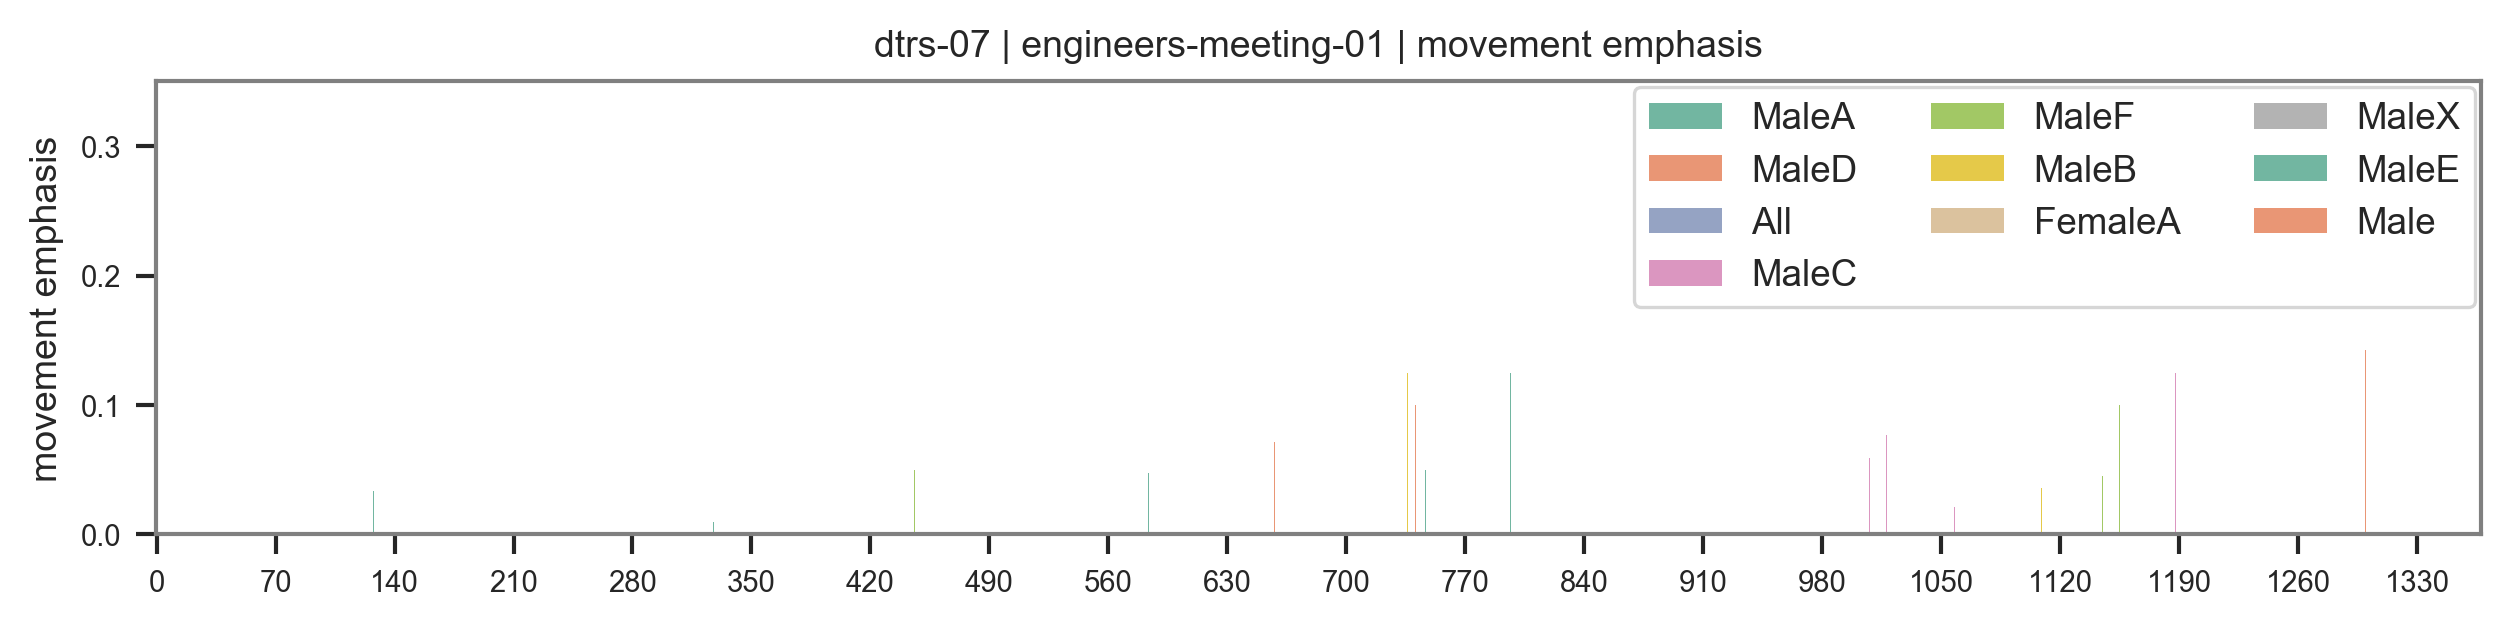

In [109]:
plot_measure(df, 'dtrs-07', 'engineers-meeting-01', 'movement emphasis')

In [143]:
print_lines(df, 'dtrs-07', 'engineers-meeting-01', movement_ny, 741, num_lines=5)

741 : MaleD


yeah so expect there's more **travel** if you smash there

----------
742 : MaleB


yeah that means you cant **move** both. yeah yeah that's right yeah. so i-its what aj suggested that this moves back-

----------
743 : MaleA


mmm

----------
744 : MaleB


to-to start to- as a (**stretch**) whereas the alternative is for that to **move** back

----------
745 : MaleA


well i suppose you could design it  only **go**-

----------


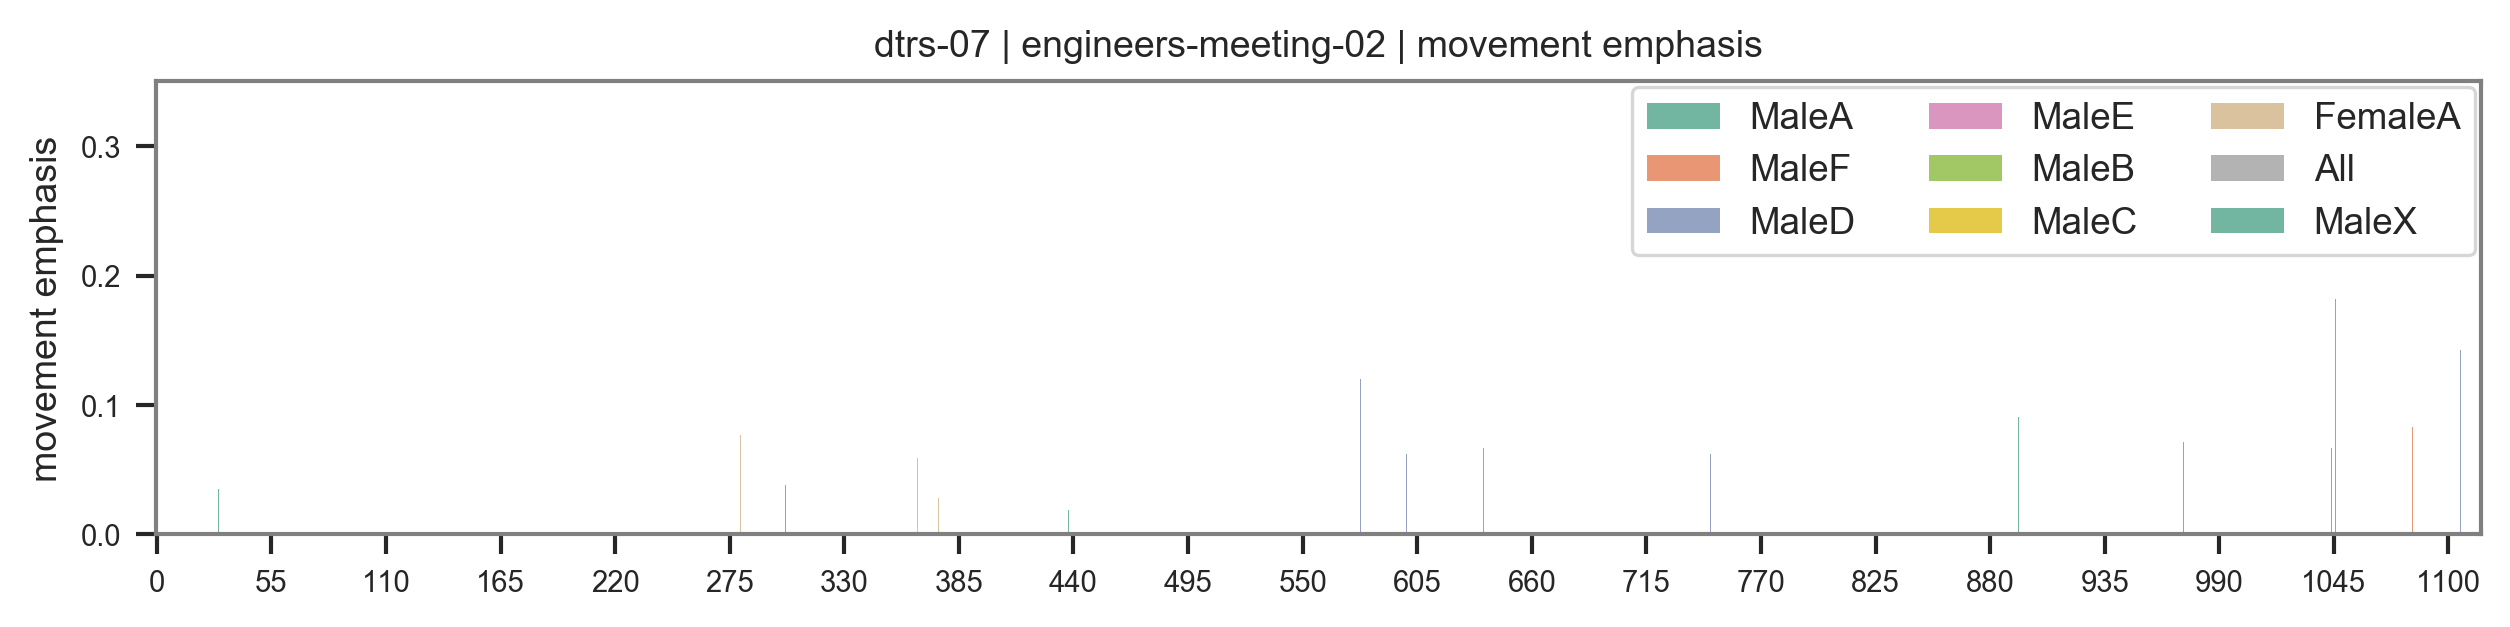

In [110]:
plot_measure(df, 'dtrs-07', 'engineers-meeting-02', 'movement emphasis')

In [146]:
# lexicon.cats['help'] # Prints out words that fall under the curated category of "help"
test_str = "The wheels on the bus might or could go round and round"
test = lexicon.analyze(test_str, categories=["movement-nytimes"])

# reg_matches


def match_subjunctives(sentence_list):
    matched_list = []
    for sentence in sentence_list :
        reg_matches = re.findall('would|could|can|might|may|if|then', sentence.lower())
        reg_split = re.split('would|could|can|might|may|if|then', sentence.lower())
        ind = 0
        matched_print = ""
        for split_string in reg_split:
            if ind == len(reg_matches) :
                str_to_concat = split_string
            else :
                str_to_concat = split_string + '**' + reg_matches[ind] + '**'
                ind += 1
            matched_print += str_to_concat
        matched_list.append(matched_print)
    return matched_list

test = match_subjunctives(["ok can i obviously ask, it seems a completely daft thing but if people are, if sikhs are walking through after the service, they obviously need to be able to get through the curtain, if we're using curtains as our committal style. at the moment once the curtains are closed you have to go through the curtains to open them"])
for t  in test :
    printmd(t)

ok **can** i obviously ask, it seems a completely daft thing but **if** people are, **if** sikhs are walking through after the service, they obviously need to be able to get through the curtain, **if** we're using curtains as our committal style. at the moment once the curtains are closed you have to go through the curtains to open them